<a href="https://colab.research.google.com/github/lesego94/Machine-Learning/blob/main/Genetic_algorithm_JSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Genetic Algorithm and the JSE

Data is from [https://github.com/dsfsi/dsfsi-datasets](https://github.com/dsfsi/dsfsi-datasets)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import sample

In [3]:
import os
import urllib.request

filename = "top40_jse_2022_performance.csv"
if not os.path.isfile(filename):
    url = "https://raw.githubusercontent.com/dsfsi/dsfsi-datasets/master/data/stocks/top40_jse_2022_performance.csv"
    urllib.request.urlretrieve(url, filename)

In [4]:
df = pd.read_csv(filename,index_col='Date')
df.head()

,PRX,ANH,NPN,BTI,GLN,CFR,BHG,AGL,AMS,FSR,...,PPH,OMU,BVT,CLS,REM,MCG,MRP,ARI,WHL,EXX
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,131583.0,99655.0,251152.0,59140.0,8126.0,23792.0,48958.0,64497.0,180356.0,6142.0,...,2205.0,1328.0,19076.0,31931.0,13214.0,12186.0,20033.0,22775.0,5206.0,15530.0
2022-01-04,133844.0,102603.0,257250.0,60300.0,8429.0,24520.0,48839.0,67220.0,185807.0,6155.0,...,2247.0,1368.0,19000.0,31919.0,13288.0,12028.0,20115.0,23619.0,5239.0,15984.0
2022-01-05,129547.0,100445.0,248359.0,59821.0,8369.0,24437.0,49892.0,67774.0,186215.0,6262.0,...,2275.0,1366.0,18990.0,31821.0,13370.0,12336.0,20040.0,24350.0,5239.0,16371.0
2022-01-06,124912.0,98505.0,239529.0,60300.0,8266.0,23944.0,50520.0,67439.0,184615.0,6275.0,...,2275.0,1360.0,18912.0,31511.0,13301.0,12240.0,20000.0,23878.0,5217.0,16287.0
2022-01-07,126200.0,97600.0,238904.0,59440.0,8373.0,23428.0,51228.0,68635.0,183451.0,6293.0,...,2290.0,1358.0,18960.0,31250.0,13157.0,12009.0,19830.0,23815.0,5230.0,16167.0


## A plot of the top stock

Text(0, 0.5, 'Stock Price, ZAR')

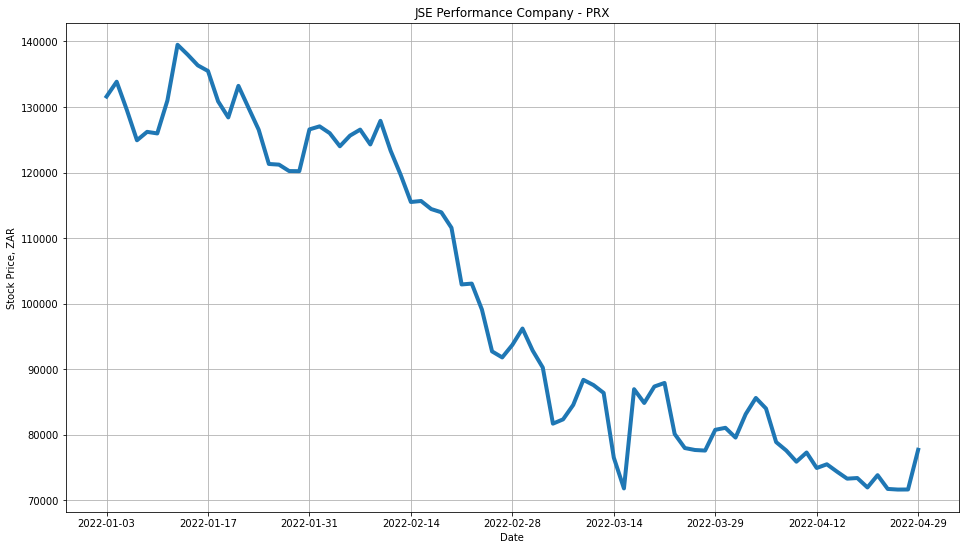

In [5]:
df.PRX.plot(figsize = (16,9),linewidth=4)
plt.grid()
plt.title("JSE Performance Company - PRX")
plt.ylabel("Stock Price, ZAR")

## 1 Stock Portfolio Allocation

It is well known that the stock market is erratic, dynamic, and nonlinear. Because of several (macro and micro) variables, including politics, international economic conditions, unforeseen occurrences, a company's financial performance, and others, it is very difficult to anticipate stock prices accurately.

It also means that there is a lot of data to look for patterns in as a result of all of this. In order to identify stock market patterns, financial analysts, academics, and data scientists continue to investigate analytics tools. This gave rise to the idea of algorithmic trading, which executes orders through the use of automated, pre-programmed trading techniques.

 In this notebook we will take a look at this problem through trying to put together a stock portfolio that would have done well through the latter shock of COVID19 in Q1 2021. 


For this problem, we will start with a weighting of the stocks. Use the `np.random.rand` function to create a random weighting for `num_dim` stocks. The weighting should always add up to 1.0 so you must adjust for this. 

In [6]:
def initialise_weighting(num_dim):
  rand_list = []
  weighting = []
  Sum = []
  total = 0
  for i in range(num_dim):
    rand_list.append(np.random.rand())
  Sum = sum(rand_list)
  for j in range(num_dim):
    weighting.append(rand_list[j]/Sum)
  return weighting

In [7]:
num_dim = 10
weighting = initialise_weighting(num_dim)
assert len(weighting) == 10
assert np.sum(weighting) < 1.00000001
assert np.sum(weighting) > 0.99999999



We now need to calculate the amount of allocated money to each stock and then calculate how many stocks would have been purchased per specific day.

**Note**: We are assuming we are buying an instrument such as an ETF, so we can buy fractions of stocks. 

In [8]:
def adjust_stocks_by_weighting(budget, weighting, stock_prices):
  
  stock = [weight*budget for weight in weighting]
  stock_weighting = stock/stock_prices
  return stock_weighting


In [9]:
budget = 5.0
weighting = np.array([0.2, 0.2 ,0.2 ,0.2, 0.2])
stock_prices = np.array([1, 2, 2, 4, 5])
stock_weighting = adjust_stocks_by_weighting(budget, weighting, stock_prices)
print(stock_weighting)

[1.   0.5  0.5  0.25 0.2 ]


In [10]:
budget = 5.0
weighting = np.array([0.2, 0.2 ,0.2 ,0.2, 0.2])
stock_prices = np.array([1, 2, 2, 4, 5])
stock_weighting = adjust_stocks_by_weighting(budget, weighting, stock_prices)
assert len(stock_weighting) == 5
assert stock_weighting[0] == 1.0
assert np.isclose(stock_weighting[2],0.5,atol=0.0001)

### Rules for our stock picking problem

1. Every stock has its own cost that is charged per stock per month
2. Every run of this algorithm will have a different budget given to you
3. Non linearities are introduced by having different tiered costs added in [e.g. having more than 10 stocks in your portfolio has extra costs added per month, as well as having more then 20 etc.]
4. We are going to assume costs are calculated daily and adjusted by the number of days in the year. Then summed. 

### 1.3 Calculating values and costs

* Provide a simple calculation to give the complete value of the portfolio given the stock_weighting and individual stock prices. This should be implemented in `portfolio_value`
* Calculate the cost of the porfolio given values for a specifi. Assume a 
    * *2%* per share per annum cost for up to 5 shares, 
    * *1%* per share per annum for 10 Shares (we have more than 5 unique shares, but less than 11), 
    * *0.75%* per share per annum for up to 20 shares,
    * and a 50% cost per share per annum for more than 20 shares in the portfolio (having more then 20). 
Implement this in `portfolio_costs`    

In [11]:
def portfolio_value(stock_weighting, stock_prices):
    stock_prices = np.nan_to_num(stock_prices)
    value = 0
    for i  in range(len(stock_prices)):
      value += stock_prices[i]*stock_weighting[i]    
    return value

def portfolio_costs(stock_weighting, period_stock_values):
    num_unique_stocks = len(stock_weighting) ## How many unique shares do you have.

    daily_cost = []
    for day_stock_value in period_stock_values:
        day_stock_value  = np.nan_to_num(day_stock_value)
        if num_unique_stocks <= 5:
          daily_cost.append(0.02*portfolio_value(stock_weighting,day_stock_value))    
        if num_unique_stocks > 5 and num_unique_stocks <= 10: 
          daily_cost.append(0.01*portfolio_value(stock_weighting,day_stock_value))  
        if num_unique_stocks > 10 and num_unique_stocks <= 20: 
          daily_cost.append(0.0075*portfolio_value(stock_weighting,day_stock_value))  
        if num_unique_stocks > 20:
          daily_cost.append(0.5*portfolio_value(stock_weighting,day_stock_value))       

    full_cost = np.sum(daily_cost)/365.0
    return full_cost

In [12]:
stock_weighting = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
stock_price = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) 
value = portfolio_value(stock_weighting, stock_price)
assert np.isclose(value,10.0,atol=0.001)

stock_weighting = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
period_stock_values = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]) # 2 Days
full_cost = portfolio_costs(stock_weighting,period_stock_values)
assert np.isclose(full_cost,0.02/365,atol=0.001)

stock_weighting = np.array([0.25, 3.0, 1])
period_stock_values = np.array([[100, 50, 75],[101, 44, 69],[99, 55, 68]]) # 3 Days
full_cost = portfolio_costs(stock_weighting,period_stock_values)
assert np.isclose(full_cost,0.04022,atol=0.0201)



## 2 Genetic Algorithm


### 2.1 Chromosome and populaton



In [13]:
def initialise_chromosome(chromosome_size):
    chromosome = initialise_weighting(chromosome_size)
    return chromosome
def initialise_population(population_size, chromosome_size):
    population = []
    for i in range(population_size):
        population.append(initialise_chromosome(chromosome_size))
    return population

In [14]:
num_stocks = 40
chromosome = initialise_chromosome(num_stocks)
print(chromosome)
population_size =10
population = initialise_population(population_size, num_stocks)

[0.0024920614805927998, 0.04959278271820462, 0.004393498248290819, 0.013780634457966755, 0.03845114542826587, 0.023863770704381795, 0.0191716434585747, 0.0321202169293795, 0.019119226914256406, 0.007288385649005666, 0.021253528721078722, 0.025645713033133195, 0.02290542008441779, 0.04252234274679775, 0.022282870589701072, 0.0014597136209538617, 0.028390829932705513, 0.02377609497373858, 0.01525159497812211, 0.013361035431370887, 0.025836883196585156, 0.00437152777374597, 0.028375690490216734, 0.036166949714846595, 0.051150997019544564, 0.02361386562950705, 0.035937429568676627, 0.017962085954964416, 0.04331412183677072, 0.04368538521918099, 0.0472399818904362, 0.014565047789532047, 0.03641998976457794, 0.009090555844424603, 0.02124500691105762, 0.018239472012704094, 0.04031672441104057, 0.0064940521574361355, 0.0514494148772553, 0.01740230783655823]


### 2.2 Calculate fitness

Fitness the is potfolio value on the last day at hand, and the cost is the total cost since buying the stock. 

In [15]:
def calculate_fitness(population, budget, stock_prices_timeline):
    fitness_list = []
    for chromosome in population:
        # Weighting at the beginning of the period
        stock_weighting = adjust_stocks_by_weighting(budget ,chromosome, stock_prices_timeline.iloc[0].values) 
        
        value = portfolio_value(stock_weighting, stock_prices_timeline.iloc[-1].values)
        cost = portfolio_costs(stock_weighting, stock_prices_timeline.iloc[1:].values)
        # Value at the end of the period
        fitness_list.append(value - cost)
    return fitness_list

In [16]:
budget = 1000000
# Stock prices from the last day of January 2022
stock_prices_timeline = df.loc["2022-01-31":]
calculate_fitness(population, budget, stock_prices_timeline)[:5]

[908445.3828792028,
 892140.0654579315,
 898281.0630435551,
 923084.1637532961,
 913480.4967463965]

### 2.3 Selection. Pairing, Crossover and Mutation

This is were the magic happens. We will be giving the selection and pairing code. We must implement the child generation and mutation code.

In [17]:
def selection(population, fitness_list):
    ## Select the top half of the best of the population
    population = np.array(population)
    sorted_indices = np.argsort(fitness_list)
    selection_point = int(1+ len(fitness_list)/2)
    
    # Randomply permute this top half of the poulation
    indices = np.random.choice(sorted_indices[selection_point:], len(population))
    best_population = population[indices]
    return best_population

def pairing(selected_population):
    ## pair up parents that will be used to reproduce
    count = 0
    pairs = []
    while count < len(selected_population)-1:
        index = count
        pairs.append([selected_population[index],selected_population[index+1]])
        count +=2
    return pairs

### 2.3.1 Create child, reproduce 

Implement the child generation.  We will use a weighted average cross over. 

An example is shown below

**Step 1:**

Parent_A - [0.2, 0.2, 0.2, 0.2, 0.2]

Parent_B - [0.4, 0.1, 0.1, 0.2, 0.2]

**Step 2:** Randomly Weighted Average Between parents to create a child

Draw weight for A randomly from 0 to 1 (use np.random.uniform()) 

e.g. **a_weight** = 0.5

> **b_weight** = 1.0 - **a_weight**. 

In ths example **b_weight** =0.5


Child - **a_weight** x Parent_A + **b_weight** x Parent_B

**Finally:**

Child - [0.3, 0.15, 0.15, 0.2, 0.2]

In [18]:
def create_child(a,b):
    child = []
    a_weight =np.random.uniform() 
    b_weight = 1 - a_weight
    child = a_weight*a + b_weight*b
    return child

def cross_over(pairs):    
    final_population = []
    for a,b in pairs:
        child = create_child(a,b)
        final_population.append(child)
        child = create_child(b,a)
        final_population.append(child)
    return final_population


In [19]:
pairs = [[np.array([0.1,0.5,0.4]),np.array([0.2,0.3,0.5])]]
child = create_child(pairs[0][0],pairs[0][1])
assert len(child) == 3
assert np.sum(child) == 1.0
assert np.max(child) <= 1.0
assert np.min(child) >= 0.0

### 2.3.2 Mutation
will get as input a population of chrosmosomes. For each chromosome, We can can add noise to the whole chromosome. Control the amount of noise using a scale factor. 


*Input:* Population of chromosomes
*Output:* Population of chromosomes that had added noise. And then normalised to add back to one. 

In [20]:
def mutation(population, scale_factor=0.05):
  final_population = []
  chromosone_list = []
  for chromosone in population:
    chromosone_list = []
    Sum = 0
    for gene in chromosone:
      gene_noise = abs(np.random.normal(gene, 0.01))
      chromosone_list.append(gene_noise)
    Sum = sum(chromosone_list)
    chromosone_list = np.array(chromosone_list)/Sum
    final_population.append(chromosone_list)
  return final_population

In [21]:
population = [[0,1]]
output = mutation(population)
assert len(output) == 1
assert len(output[0]) == 2
assert np.isclose(np.sum(output[0]),1.0)
assert output[0][0] != population[0][0]
population = [[0,0.4,0.6]]
output = mutation(population)
assert len(output) == 1
assert len(output[0]) == 3
assert np.isclose(np.sum(output[0]),1.0)
assert output[0][0]  > 0

### 2.3.3 Putting it all together

In [22]:
num_stocks = 40
population_size = 100
num_iterations = 1000
budget = 1000000
# Stock prices from the last day of January 2022
stock_prices_timeline = df.loc["2022-01-31":]

In [23]:
# Genetic Algorithm
population= initialise_population(population_size=population_size, chromosome_size=num_stocks)
best_performance = -1000000
best_chromosome = []
best_performance_history = []
performance_history = []
for i in range(num_iterations):
    # Calculate the fitness of all chromosomes in the population
    performances = calculate_fitness(population, budget, stock_prices_timeline)
    # If the new population has the best distance, save it.
    if np.max(performances) > best_performance:
        best_performance = np.max(performances)
        best = np.argmax(performances)
        best_chromosome = population[best]
        best_performance_history.append(best_performance)
    performance_history.append(np.mean(performances))
    # 1. Do selection
    selected_population = selection(population, performances)
    # 2. Pair the good chromosomes 
    pairs = pairing(selected_population)
    # 3. Reproduce with cross over
    crossed_over = cross_over(pairs)
    # 4. Add some randomness with mutation
    population = mutation(crossed_over)

performances = calculate_fitness(population, budget, stock_prices_timeline)
# If the new population has the best distance, save it.
if np.max(performances) > best_performance:
    best_performance = np.max(performances)
    best = np.argmax(performances)
    best_chromosome = population[best]
    best_performance_history.append(best_performance)
performance_history.append(np.mean(performances))
print("Distances: " ,performances[:5])
print("Population: ",population[:2])
print("Best chromosome: ",best_chromosome)
print("Best (shortest) distance: ",best_performance)

Distances:  [1005904.9119491238, 1003561.2273852564, 979401.8528526095, 1010896.7468484606, 1016946.7560905867]
Population:  [array([0.02216959, 0.01184332, 0.02149121, 0.01787432, 0.0659957 ,
       0.00081854, 0.00822939, 0.00774984, 0.01041315, 0.01602209,
       0.03008168, 0.04088487, 0.028152  , 0.01658171, 0.00611869,
       0.03934435, 0.02388696, 0.00522898, 0.02660647, 0.03468364,
       0.11230446, 0.01315974, 0.01493391, 0.01637293, 0.01002156,
       0.00915273, 0.01214306, 0.01380781, 0.04222717, 0.01915958,
       0.01259803, 0.02643927, 0.02168616, 0.04156281, 0.02473297,
       0.02907483, 0.00764461, 0.01111573, 0.04549488, 0.08219124]), array([0.00675044, 0.00057537, 0.00063609, 0.02843725, 0.06657667,
       0.00037453, 0.01497063, 0.03333894, 0.00499986, 0.03105935,
       0.04353057, 0.00031807, 0.01883001, 0.01667985, 0.03262411,
       0.02221189, 0.00917185, 0.01475709, 0.02485183, 0.03130085,
       0.11769597, 0.03708372, 0.00607017, 0.03228212, 0.02414146,
 

In [24]:
stock_weighting = adjust_stocks_by_weighting(budget ,best_chromosome, stock_prices_timeline.iloc[0].values)
stock_weighting_avg = adjust_stocks_by_weighting(budget ,np.ones(40)/40, stock_prices_timeline.iloc[0].values)

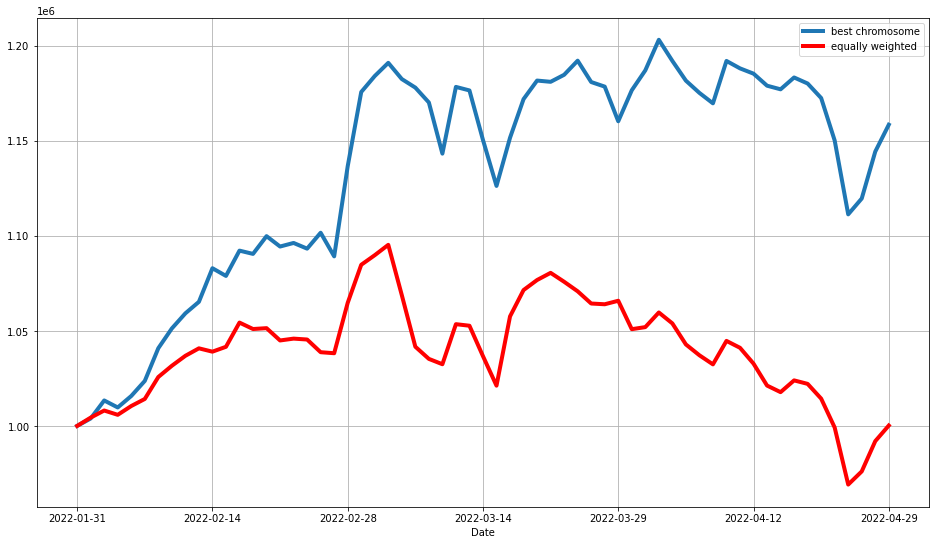

In [25]:
avg = stock_weighting*stock_prices_timeline
avg.sum(axis=1).plot(figsize=(16,9), label='best chromosome',linewidth=4)
equally = stock_weighting_avg*stock_prices_timeline
equally.sum(axis=1).plot(figsize=(16,9), color='r', label='equally weighted',linewidth=4)
plt.grid()
plt.legend()

Text(0.5, 0, 'Sample number')

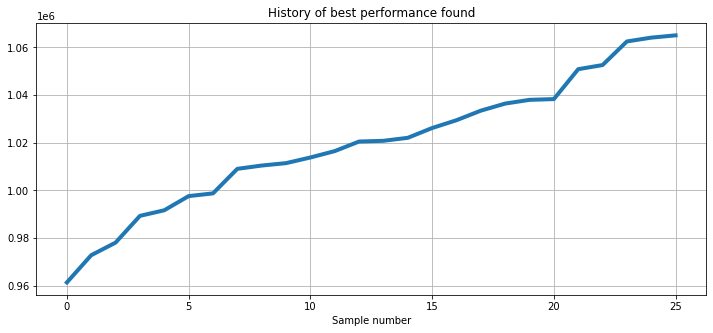

In [26]:
plt.figure(figsize= (12,5))
plt.plot(best_performance_history,linewidth=4)
plt.title("History of best performance found")
plt.grid()
plt.xlabel("Sample number")

Text(0.5, 0, 'Sample number')

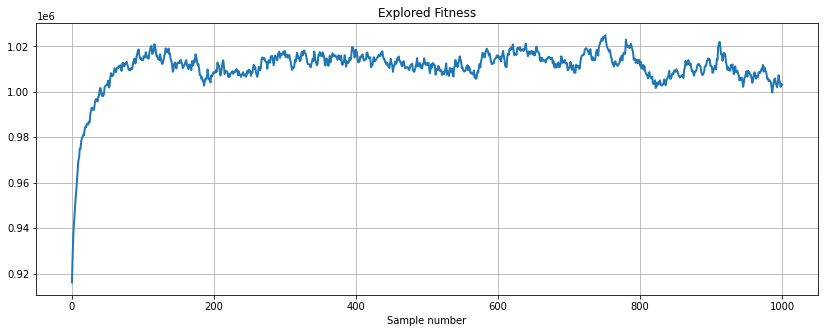

In [27]:
plt.figure(figsize= (14,5))
plt.plot(performance_history,linewidth=2)
plt.title("Explored Fitness")
plt.grid()
plt.xlabel("Sample number")

Text(0.5, 0, 'Sample number')

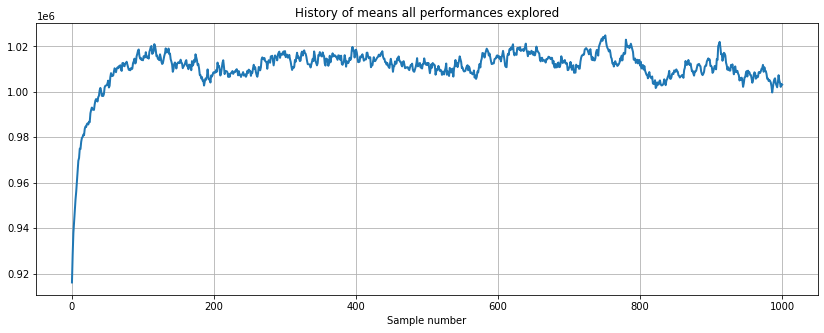

In [28]:
plt.figure(figsize= (14,5))
plt.plot(performance_history,linewidth=2)
plt.title("History of means all performances explored")
plt.grid()
plt.xlabel("Sample number")

The fitness function needs to be computationaly inexpensive given the number of times it needs to be run, doing so will allow the algorithm to run faster and more efficiently. The fitness function in this case is made up of the costs function which is constructed from a number of if statements which are computationaly expensive to do.
One way the mutation can be improved is by adjusting the scale_factor which will increase or decrease the noise applied to a chromosone, then observing its effect on the solution. One can also apply a different mutation process and instead of applying noise, one can scramble the genes, invert a subset of genes or swap select genes. Doing so does change the fitness value, fine tuning these variables will lead to an improved solution.

